# Evaluating Topic Models with Word Embedding

A topic is 'good' if 
- the terms describing it are *coherent*. Many [coherence metrics](http://qpleple.com/topic-coherence-to-evaluate-topic-models/) are available and `gensim` [has implemented](https://markroxor.github.io/gensim/static/notebooks/topic_coherence_tutorial.html) a few of them. [This study](http://eprints.gla.ac.uk/119284/1/119284.pdf) shows that word embedding yields a better performance than those coherence metrics. 
- the documents associated with it are *semantically similar*. There are many ways to measure document similarity, and we can use word embedding again here.

*Following this direction, this notebook will look into the use of word embedding in evaluating topic models.*

In [79]:
import json
import nlp

import numpy as np
import pandas as pd

from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler

from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.colors import RGB

output_notebook()

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##  Topic modelling with LDA
We will use a small [Lee Background Corpus](https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf), which contains 300 short news.

In [3]:
data = nlp.load_file('../data/lee.txt')
docs = nlp.preprocess(data)
len(data), data[0], docs[0]

(300,
 'Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are availabl

Apply LDA with 10 topics.

In [4]:
lda = nlp.build_lda(docs, num_topics=10)
lda.print_topics()

[(0,
  '0.030*"afghanistan" + 0.025*"bin" + 0.025*"force" + 0.022*"laden" + 0.018*"qaeda" + 0.015*"afghan" + 0.015*"taliban" + 0.014*"united" + 0.014*"fighter" + 0.012*"state"'),
 (1,
  '0.018*"centre" + 0.016*"rate" + 0.015*"per" + 0.013*"cent" + 0.013*"police" + 0.012*"one" + 0.010*"three" + 0.010*"time" + 0.010*"bank" + 0.010*"australian"'),
 (2,
  '0.047*"fire" + 0.026*"new" + 0.018*"area" + 0.018*"sydney" + 0.017*"south" + 0.016*"company" + 0.013*"today" + 0.013*"wind" + 0.012*"also" + 0.011*"one"'),
 (3,
  '0.053*"palestinian" + 0.035*"israeli" + 0.031*"arafat" + 0.017*"attack" + 0.017*"israel" + 0.016*"hamas" + 0.014*"leader" + 0.014*"official" + 0.013*"gaza" + 0.013*"suicide"'),
 (4,
  '0.025*"worker" + 0.024*"qantas" + 0.023*"union" + 0.019*"action" + 0.018*"australian" + 0.016*"airline" + 0.014*"metre" + 0.014*"industrial" + 0.014*"company" + 0.013*"test"'),
 (5,
  '0.032*"report" + 0.031*"commission" + 0.030*"people" + 0.017*"union" + 0.016*"royal" + 0.014*"job" + 0.014*"hea

## Projection of documents based on topics

To project documents, we use the doc-topic matrix, in which each row is a vector of topic probability. 

In [5]:
corpus = [lda.id2word.doc2bow(doc) for doc in docs]
doc_topic_matrix = nlp.get_doc_topic_matrix(lda, corpus)
doc_topic_matrix.shape

(300, 10)

We want to color code documents by their strongest topics.

In [6]:
topic_ids = nlp.get_strongest_document_topics(lda, corpus)
topic_ids

[2,
 7,
 9,
 7,
 9,
 6,
 8,
 2,
 2,
 2,
 2,
 2,
 7,
 3,
 3,
 1,
 8,
 8,
 9,
 2,
 1,
 9,
 9,
 8,
 2,
 2,
 7,
 8,
 7,
 3,
 5,
 1,
 2,
 2,
 7,
 0,
 2,
 8,
 1,
 2,
 2,
 0,
 2,
 9,
 3,
 7,
 2,
 8,
 2,
 2,
 0,
 5,
 8,
 9,
 1,
 8,
 0,
 7,
 0,
 8,
 3,
 6,
 2,
 1,
 6,
 0,
 9,
 4,
 3,
 7,
 6,
 7,
 8,
 6,
 7,
 7,
 9,
 1,
 9,
 1,
 9,
 3,
 7,
 6,
 1,
 3,
 9,
 2,
 0,
 1,
 6,
 4,
 1,
 3,
 7,
 9,
 2,
 0,
 0,
 2,
 6,
 4,
 9,
 4,
 4,
 1,
 9,
 0,
 1,
 2,
 3,
 4,
 4,
 1,
 0,
 9,
 3,
 4,
 8,
 9,
 4,
 1,
 7,
 5,
 9,
 1,
 1,
 0,
 4,
 1,
 4,
 3,
 8,
 0,
 3,
 4,
 9,
 4,
 9,
 8,
 0,
 0,
 0,
 3,
 9,
 3,
 8,
 9,
 3,
 5,
 4,
 5,
 3,
 0,
 7,
 7,
 4,
 8,
 5,
 0,
 7,
 4,
 9,
 7,
 9,
 9,
 0,
 0,
 4,
 9,
 1,
 9,
 9,
 3,
 9,
 4,
 0,
 3,
 6,
 4,
 7,
 1,
 8,
 0,
 3,
 6,
 7,
 4,
 2,
 9,
 6,
 8,
 0,
 9,
 7,
 4,
 1,
 3,
 6,
 5,
 0,
 3,
 5,
 4,
 1,
 4,
 6,
 4,
 3,
 7,
 7,
 1,
 8,
 8,
 1,
 5,
 6,
 7,
 7,
 1,
 3,
 1,
 2,
 2,
 8,
 8,
 0,
 3,
 9,
 9,
 8,
 1,
 4,
 0,
 7,
 3,
 8,
 1,
 5,
 7,
 1,
 4,
 3,
 0,
 1,
 1,
 4,
 2,
 9,
 0,


In [7]:
def compute_tsne(vectors):
    'Return a 2D projection of high-dimensional vectors.'
    return manifold.TSNE(perplexity=100, random_state=0).fit_transform(vectors)

In [8]:
doc_coords = compute_tsne(doc_topic_matrix)
doc_coords

array([[ 2.7510962 ,  1.0616773 ],
       [-0.21586555, -1.2398055 ],
       [ 5.0623317 ,  4.67161   ],
       [ 1.312572  ,  0.35652983],
       [ 3.5068698 ,  2.9477763 ],
       [-2.0121436 ,  4.7746043 ],
       [ 1.0863571 ,  4.5639014 ],
       [ 2.4108233 ,  1.7455044 ],
       [ 2.7505324 ,  1.060254  ],
       [ 2.773066  ,  1.809787  ],
       [ 3.1028302 ,  1.7065911 ],
       [ 2.759447  ,  1.0807164 ],
       [-0.2223286 , -1.2466239 ],
       [ 2.835495  ,  5.894704  ],
       [ 2.7850854 ,  7.7861357 ],
       [ 5.011433  ,  1.1363974 ],
       [ 1.3687053 ,  4.249769  ],
       [ 0.8992381 ,  4.2643924 ],
       [ 5.274814  ,  4.5053906 ],
       [ 2.2638729 ,  2.0688255 ],
       [ 5.6561093 ,  1.3198421 ],
       [ 4.689231  ,  4.4913692 ],
       [ 5.0205708 ,  4.0915627 ],
       [ 0.90997064,  4.304975  ],
       [ 2.4062219 ,  1.9853631 ],
       [ 3.7030907 ,  1.2340072 ],
       [-0.20501845, -1.2302477 ],
       [ 1.8578026 ,  2.894812  ],
       [ 0.823919  ,

limit_output extension: Maximum message size of 10000 exceeded with 10515 characters

In [9]:
def plot_projection(coords, topic_ids, palette):
    'Plot documents and color code their topics.'
    df = pd.DataFrame(data=np.c_[coords, topic_ids], columns= ['x', 'y', 'topic'])
    df.topic = df.topic.astype(int)
    sns.lmplot(data=df, x='x', y='y', hue='topic', palette=palette, fit_reg=False, size=6, aspect=1.6)

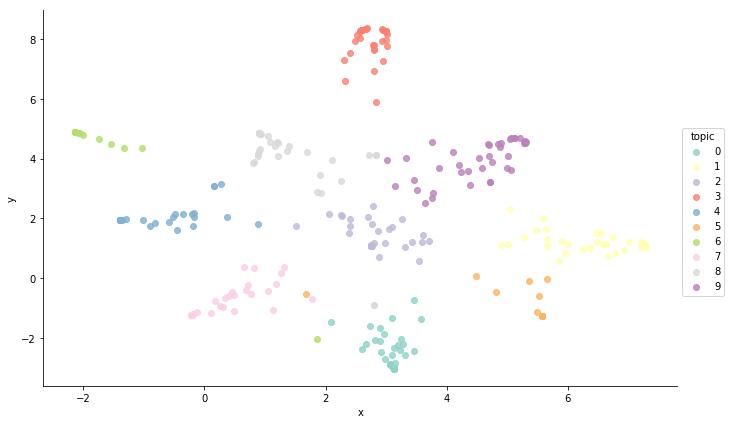

In [10]:
plot_projection(doc_coords, topic_ids, 'Set3')

Great! We can see clear clusters of documents by topics. It doesn't mean that the resultant topics are good because the projection and the topic ID use the same source of information: the (document, topic) distribution. It shows that t-sne projection is quite good. Let's try other projections.

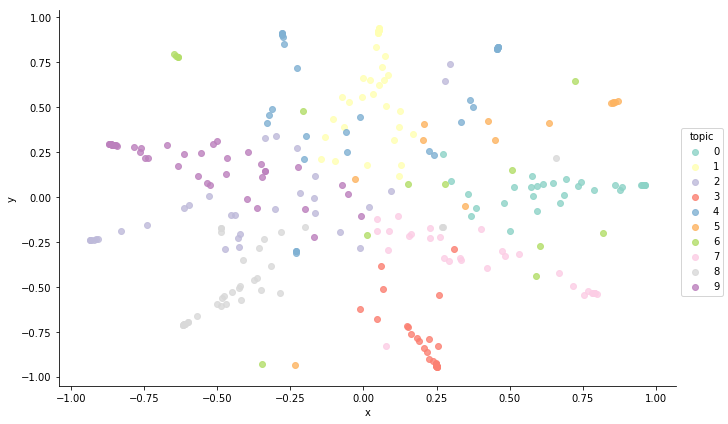

In [11]:
plot_projection(manifold.MDS().fit_transform(doc_topic_matrix), topic_ids, 'Set3')

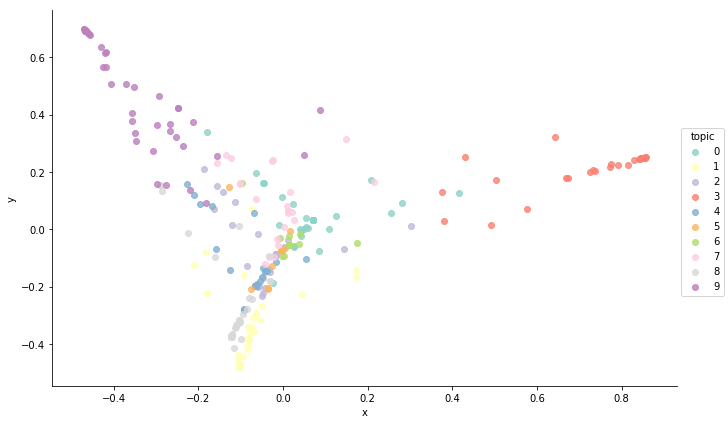

In [12]:
from sklearn import decomposition
plot_projection(decomposition.PCA(n_components=2).fit_transform(doc_topic_matrix), topic_ids, 'Set3')

It looks like t-sne > MDS > PCA (with default parameters).

## Projection of documents with doc2vec

In [13]:
docvecs = nlp.build_doc2vec(docs).docvecs
doc2vec_matrix = np.concatenate([docvecs[i].reshape(1, -1) for i in range(len(docvecs))])
doc_coords_doc2vec = compute_tsne(doc2vec_matrix)

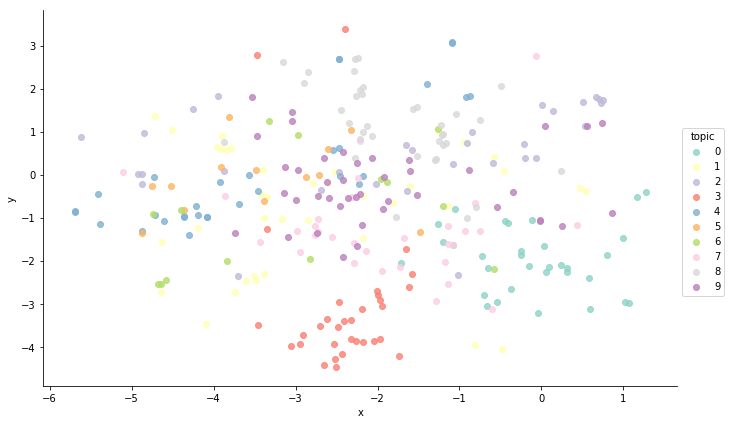

In [14]:
plot_projection(doc_coords_doc2vec, topic_ids, 'Set3')

We can see some structure there, but not as clear as the projection using doc-topic matrix. Topic 3 (purple) is good. Let's look at cosine similarity between documents using doc2vec ouput.

In [15]:
def get_doc_doc_similarity(doc2vec_matrix):
    'Return a doc-doc similarity matrix based on a doc2vec_matrix.'
    def compute_one(docvec):
        return (KeyedVectors.cosine_similarities(docvec, doc2vec_matrix).reshape(1,-1) + 1) / 2
    
    return np.concatenate([compute_one(docvec) for docvec in doc2vec_matrix])

In [16]:
doc_doc_matrix = get_doc_doc_similarity(doc2vec_matrix)
doc_doc_matrix.shape

(300, 300)

Compare intra-topic document similarity and inter-topic document similarity.

In [17]:
def compute_sim_docs(doc_doc_matrix, topic_id, topic_ids):
    'Return average similarity between pairs of documents within/without a topic.'
    
    def avg_two_sets(set1, set2):
        return np.mean([doc_doc_matrix[i][j] for i in set1 for j in set2])

    doc_indices = [i for i in range(len(topic_ids)) if topic_ids[i] == topic_id]
    outdoc_indices = [i for i in range(len(topic_ids)) if topic_ids[i] != topic_id]
    intra_sim = avg_two_sets(doc_indices, doc_indices)
    inter_sim = avg_two_sets(doc_indices, outdoc_indices)
        
    return intra_sim, inter_sim

In [18]:
for i in range(10):
    print('topic', i, compute_sim_docs(doc_doc_matrix, i, topic_ids))

topic 0 (0.68823045, 0.57504565)
topic 1 (0.62528837, 0.5929648)
topic 2 (0.6583142, 0.58953464)
topic 3 (0.7281666, 0.569849)
topic 4 (0.69662005, 0.5983504)
topic 5 (0.66972923, 0.60019255)
topic 6 (0.67380416, 0.59534866)
topic 7 (0.65815437, 0.5934492)
topic 8 (0.7004258, 0.5964052)
topic 9 (0.6530787, 0.60066634)


For all topics, similarity between documents in the same topic is larger than that between documents in other topics, but not much difference. Topic 3 has the best one, aligned with the t-sne projection.

## Color-coding documents with similarity
I think of two ways: 
- project doc embeddings to 3D and use the coordinates as RGB colors
- use [HSL color space](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a0/Hsl-hsv_models.svg/1200px-Hsl-hsv_models.svg.png) with fixed value of L=0.5, so we map the 2D projection to a color wheel

### 3D projection as RGB

In [19]:
def plot3d(coords, colors):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], c=colors, s=50)

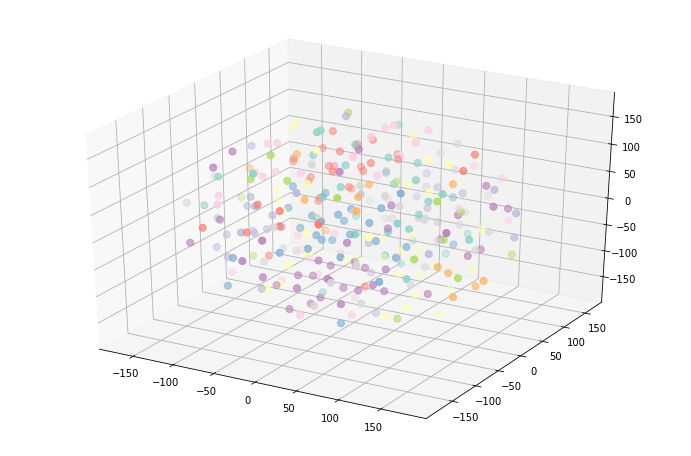

In [20]:
colors = [sns.color_palette('Set3', 10)[t] for t in topic_ids]
doc_coords3d = manifold.TSNE(perplexity=100, random_state=0, n_components=3).fit_transform(doc_topic_matrix)
plot3d(doc_coords3d, colors)

Well, 3d t-sne projection doesn't look good. Let's try MDS.

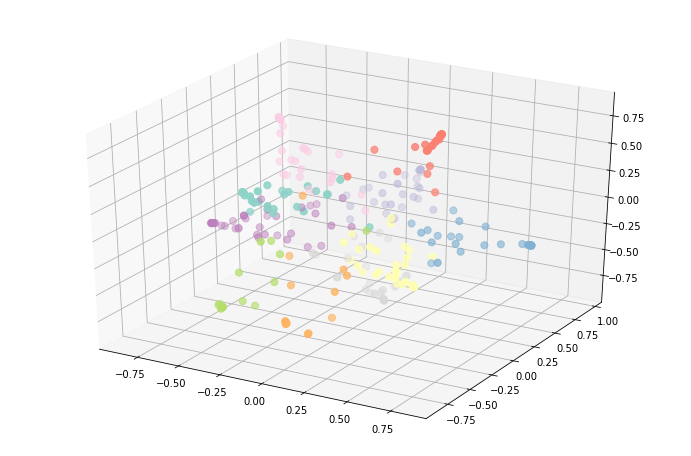

In [21]:
doc_coords3d = manifold.MDS(n_components=3).fit_transform(doc_topic_matrix)
plot3d(doc_coords3d, colors)

Wow, much better! Now, instead of coloring based on topics, I will color using the 3d coordinates.

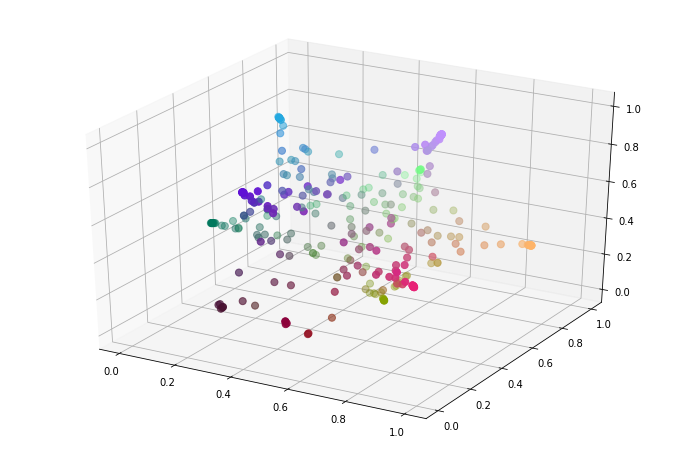

In [22]:
doc_coords3d = MinMaxScaler().fit_transform(doc_coords3d) # rgb color space requires 0-1 components
plot3d(doc_coords3d, doc_coords3d)

### 2D projection as HSL color wheel

In [23]:
import colorsys

def angle_between(v1, v2):
    return np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * (np.linalg.norm(v2))))

def get_h(x, y):
    a = angle_between((x, y), (1, 0)) / np.pi / 2
    return a if y >= 0 else 1 - a

def get_max_xy(points):
    'Fit the points into a circle, centering at (0, 0). Return the radius of the circle.'
    return max(np.linalg.norm(p) for p in points)

def get_s(x, y, scale):
    return np.linalg.norm((x, y)) / scale
    
def get_2dcolor(points):
    max_xy = get_max_xy(points)
    return [colorsys.hls_to_rgb(get_h(*p), 0.5, get_s(*p, max_xy)) for p in points]

Let's start with the doc-topic matrix to see if the color coding works well before using doc2vec.

In [24]:
doc_colors = get_2dcolor(doc_coords)

In [25]:
def plot2d(coords, colors):
    plt.figure(figsize=(12,8))
    plt.scatter(coords[:,0], coords[:,1], c=colors, s=50)

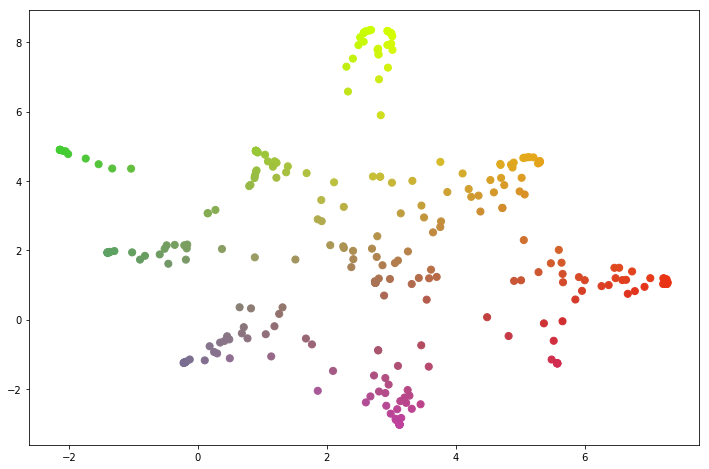

In [26]:
plot2d(doc_coords, doc_colors)

Looks good! Now color code doc2vec.

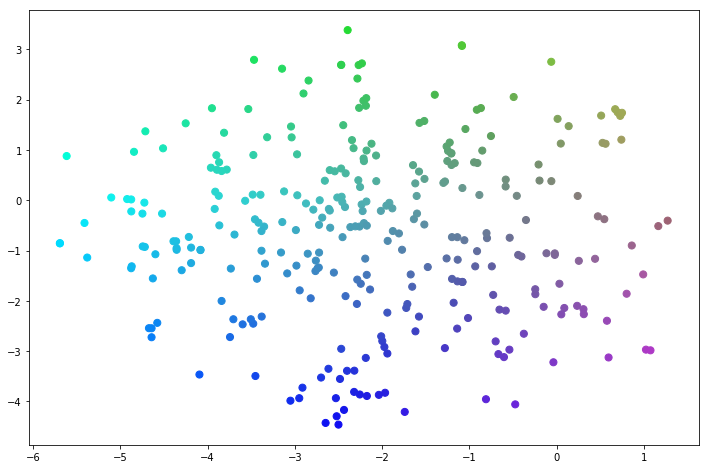

In [27]:
doc_colors_doc2vec = get_2dcolor(doc_coords_doc2vec)
plot2d(doc_coords_doc2vec, doc_colors_doc2vec)

Not bad? I can see a smooth change in color.

## Term similarity with word2vec as topic coherence

In [28]:
sentences = nlp.preprocess(nlp.split_sentences('. '.join(data)))
len(sentences), sentences[0]

(2748,
 ['hundred',
  'people',
  'forced',
  'vacate',
  'home',
  'southern',
  'highland',
  'new',
  'south',
  'wale',
  'strong',
  'wind',
  'today',
  'pushed',
  'huge',
  'bushfire',
  'towards',
  'town',
  'hill',
  'top'])

In [29]:
word2vec = nlp.build_word2vec(sentences)
wordvecs = word2vec.wv

We can apply t-sne projection to show all terms in the dictionary and color code them using 2D color space.

In [30]:
term_topic_ids = nlp.get_strongest_term_topics(lda, wordvecs.vocab)
topic_term_matrix = np.concatenate([wordvecs[t].reshape(1, -1) for t in wordvecs.vocab])
term_coords_word2vec = compute_tsne(topic_term_matrix)

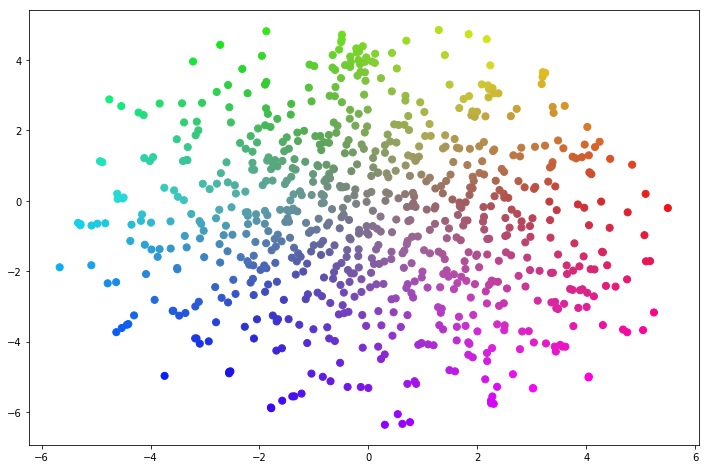

In [31]:
term_colors_word2vec = get_2dcolor(term_coords_word2vec)
plot2d(term_coords_word2vec, term_colors_word2vec)

Now, let's check intra-topic similarity and whole dictionary similiarity.

In [32]:
from itertools import combinations

def compute_sim_terms(wv, terms):
    'Return the average similarity between all pairs of terms'
    return np.mean([wv.similarity(a, b) for (a, b) in combinations(terms, 2)])

def compute_sim_topic(wv, topic_id, lda):
    'Return average similarity between pairs of terms within a topic.'
    terms = [lda.id2word[t] for t, p in lda.get_topic_terms(topic_id, topn=5)]
    return compute_sim_terms(wv, terms)

def compute_sim_dict(wv):
    'Return average similarity between pairs of terms within a vocabulary.'
    return compute_sim_terms(wv, list(wv.vocab.keys()))

Whole dictionary.

In [33]:
compute_sim_dict(wordvecs)

0.03777293893313075

For each topic.

In [34]:
for i in range(lda.num_topics):
    print(compute_sim_topic(wordvecs, i, lda))

0.34428751838053123
0.0900525673923896
0.18805118853332448
0.46320184009023607
0.224310485771001
0.15754474697360052
-0.00507306411517996
0.13850785619924538
0.10623722511040667
0.07266152412606286


Let's show topics with the new color.

In [35]:
topics = nlp.get_topics(lda)
terms = list(wordvecs.vocab.keys())
color_lookup = {terms[i]:c for i, c in enumerate(term_colors_word2vec)} 

In [103]:
def toRGB(t):
    return RGB(t[0] * 255, t[1] * 255, t[2] * 255)
    
def build_df(topics, color_lookup):
    'Build a data frame for easy drawing in bokeh.'
    data = []
    for i, terms in enumerate(topics):
        for j, t in enumerate(terms):
            data.append({ 'topic': 'topic ' + str(i), 'term_index': 'term ' + str(j), 'term': t, 'color': toRGB(color_lookup[t]) })
    return pd.DataFrame(data)

In [104]:
df = build_df(topics, color_lookup)
df.head(10)

,color,term,term_index,topic
0,"rgb(201, 31, 223)",afghanistan,term 0,topic 0
1,"rgb(214, 5, 249)",bin,term 1,topic 0
2,"rgb(206, 44, 210)",force,term 2,topic 0
3,"rgb(216, 4, 250)",laden,term 3,topic 0
4,"rgb(210, 18, 236)",qaeda,term 4,topic 0
5,"rgb(9, 92, 245)",centre,term 0,topic 1
6,"rgb(34, 220, 109)",rate,term 1,topic 1
7,"rgb(45, 209, 78)",per,term 2,topic 1
8,"rgb(44, 210, 67)",cent,term 3,topic 1
9,"rgb(193, 61, 125)",police,term 4,topic 1


In [110]:
xrange = ['term ' + str(i) for i in range(5)]
yrange = ['topic ' + str(i) for i in range(10)]
p = figure(x_range=xrange, y_range=yrange)
source = ColumnDataSource(df)
p.rect(source=source, x='term_index', y='topic', width=1, height=0.9, fill_color='color', line_color=None)
p.text(source=source, x='term_index', y='topic', text='term', text_align='center', text_baseline='middle', text_color='white')

p.outline_line_color = None
p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_standoff = 0
p.legend.orientation = "horizontal"
p.legend.location ="top_center"

show(p)

Sort terms based on similarity to the highest probable one.

## Export RGB colors of terms

In [38]:
with open('../data/lee_term_colours.json', 'w') as f:
    json.dump(color_lookup, f)